# Bibliotecas

In [22]:
import pyedflib
import numpy as np
import pandas as pd
import commands
import pywt
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from pywt import WaveletPacket
import pywt.data
from detect_peaks import detect_peaks
%matplotlib notebook

---

## Filtros

In [23]:
def FilterSignal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = emg_filtered
    #emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    #return emg_envelope
    return emg_filtered

## Função Plot FFT

In [24]:
for i in range(Xc.shape[1]):
    X = np.abs(np.fft.fft(Xc[:, i]))

TypeError: unhashable type

In [25]:
def PlotFft(Xc, F):
    #Xc = dfn['Ch1']
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    X = np.abs(np.fft.fft(Xc[:, 0]))
    fs = np.linspace(0, F,Xc[:, 0].shape[0])
    ax1.plot(fs,X, linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 1]))
    fs = np.linspace(0, F,Xc[:, 1].shape[0])
    ax2.plot(fs,X, linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 2]))
    fs = np.linspace(0, F,Xc[:, 2].shape[0])
    ax3.plot(fs,X, linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    X = np.abs(np.fft.fft(Xc[:, 3]))
    fs = np.linspace(0, F,Xc[:, 3].shape[0])
    ax4.plot(fs,X, linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função Plot

In [26]:
def PlotFile(dfn):
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    ax1.plot(dfn['Ch1'][2000:], linewidth=0.2, color = '#B22222')
    ax1.set_title('Tremor de Intensao'+'\nCanal 1')
    ax1.set_ylabel('EMG (u.v.)')
    ax1.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax2.plot(dfn['Ch2'][2000:], linewidth=0.2, color = '#008000')
    ax2.set_title('\nCanal 2')
    ax2.set_ylabel('EMG (u.v.)')
    ax2.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax3.plot(dfn['Ch3'][2000:], linewidth=0.2)
    ax3.set_title('\nCanal 3')
    ax3.set_ylabel('EMG (u.v.)')
    ax3.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    ax4.plot(dfn['Ch4'][2000:], linewidth=0.2, color = '#FF8C00')
    ax4.set_title('\nCanal 4')
    ax4.set_ylabel('EMG (u.v.)')
    ax4.set_xlabel('Amostras')
    ax4.grid()
    plt.rc('grid', linestyle="dotted", color='black')

    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    f.set_size_inches(w=10,h=8)

## Função RMS

In [27]:
def Rms(file_):

    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)
    
    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_INTENC/'+file_+'.edf')    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    return rms

---

## Calcula a Norma de cada canal

In [29]:
#files = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'c1', 'c2', 'c3', 'c4', 'c5']

#Set validação
files = ['p1v', 'p2v', 'p3v', 'p4v', 'p5v', 'p6v', 'c1v', 'c2v', 'c3v', 'c4v', 'c5v']

peaks_rms = [ ]
norm = [ ]


def Norm(file_):
    
    #Calcula RMS
    def rms(a, window_size):
        def subrms(a, window_size):
            a2 = np.power(a,2)
            window = np.ones(window_size)/float(window_size)
            return np.sqrt(np.convolve(a2, window, 'valid'))

        for i in range(a.shape[1]):
            if i == 0:
                Xc = subrms(a[:, i], window_size)
            else:
                Xcp = subrms(a[:, i], window_size)
                Xc = np.vstack((Xc,Xcp))
        return np.transpose(Xc)  

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_INTENC/'+file_+'.edf')    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    #df.insert(loc=0, column='Time', value=np.arange(0,len(df)*0.0005,0.0005))
    
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    #dfa = df.as_matrix(columns=df.columns[1:])
    dfa = df.as_matrix()
    
    #Aplica RMS em cada canal
    rms = rms(dfa,50)
    rms = pd.DataFrame(data=rms, columns=['Ch1','Ch2','Ch3','Ch4'])
    
    #Calcula o pico RMS máximo de cada canal em cada arquivo e adiciona a lista peaks_rmslll
    peaks_rms.append([max(rms['Ch1']),max(rms['Ch2']),max(rms['Ch3']),max(rms['Ch4']),])

#Cria a lista de picos RMS máximo    
for i in files:
    Norm(i)

#Calcula o máximo global
peaks_rms = pd.DataFrame(data=peaks_rms, columns=['Ch1','Ch2','Ch3','Ch4'])
norm = [max(peaks_rms['Ch1']),max(peaks_rms['Ch2']),max(peaks_rms['Ch3']),max(peaks_rms['Ch4'])]  

print 'Norma de cada canal: \n',norm

Norma de cada canal: 
[162.33217118017379, 309.28461937761796, 369.13613218751755, 329.39346713126781]


---

## Aplica a norma em cada amostra e salva

In [30]:
def Std(file_):

    #Lê dados dos arquivos .edf
    file_name = pyedflib.EdfReader('DB_INTENC/'+file_+'.edf')    
    n = file_name.signals_in_file
    signal_labels = file_name.getSignalLabels()
    sigbufs = np.zeros((n, file_name.getNSamples()[0]))
    for j in np.arange(n):
         sigbufs[j, :] = file_name.readSignal(j)

    file_name._close()

    df = pd.DataFrame(np.transpose(sigbufs))
    dfa = df.as_matrix()
    
    #Aplica a norma em cada canal
    Xc=np.array([dfa[:,0]/norm[0],dfa[:,1]/norm[1],dfa[:,2]/norm[2],dfa[:,3]/norm[3]])
    Xc = np.transpose(Xc)
    #Salva o arquivo normalizado na pasta <preproc>
    np.save('./DB_INTENC/preproc/'+file_+'_std', Xc, allow_pickle=False)
    print file_+'_std.npy'
    
    return(pd.DataFrame(data=Xc, columns=['Ch1','Ch2','Ch3','Ch4']))

In [31]:
for i in files:
    Std(i)

p1v_std.npy
p2v_std.npy
p3v_std.npy
p4v_std.npy
p5v_std.npy
p6v_std.npy
c1v_std.npy
c2v_std.npy
c3v_std.npy
c4v_std.npy
c5v_std.npy


In [32]:
Std('c5v').head()

c5v_std.npy


,Ch1,Ch2,Ch3,Ch4
0,-0.030242,0.001860,-0.013754,-0.012991
1,-0.021577,-0.016322,-0.009943,-0.017301
2,-0.012912,-0.043595,-0.002321,0.012866
3,0.004418,0.006405,0.001490,-0.025920
4,0.004418,-0.061777,0.005301,-0.008682


In [33]:
c = np.load('DB_INTENC/preproc/c5v_std.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,-0.030242,0.001860,-0.013754,-0.012991
1,-0.021577,-0.016322,-0.009943,-0.017301
2,-0.012912,-0.043595,-0.002321,0.012866
3,0.004418,0.006405,0.001490,-0.025920
4,0.004418,-0.061777,0.005301,-0.008682


<IPython.core.display.Javascript object>


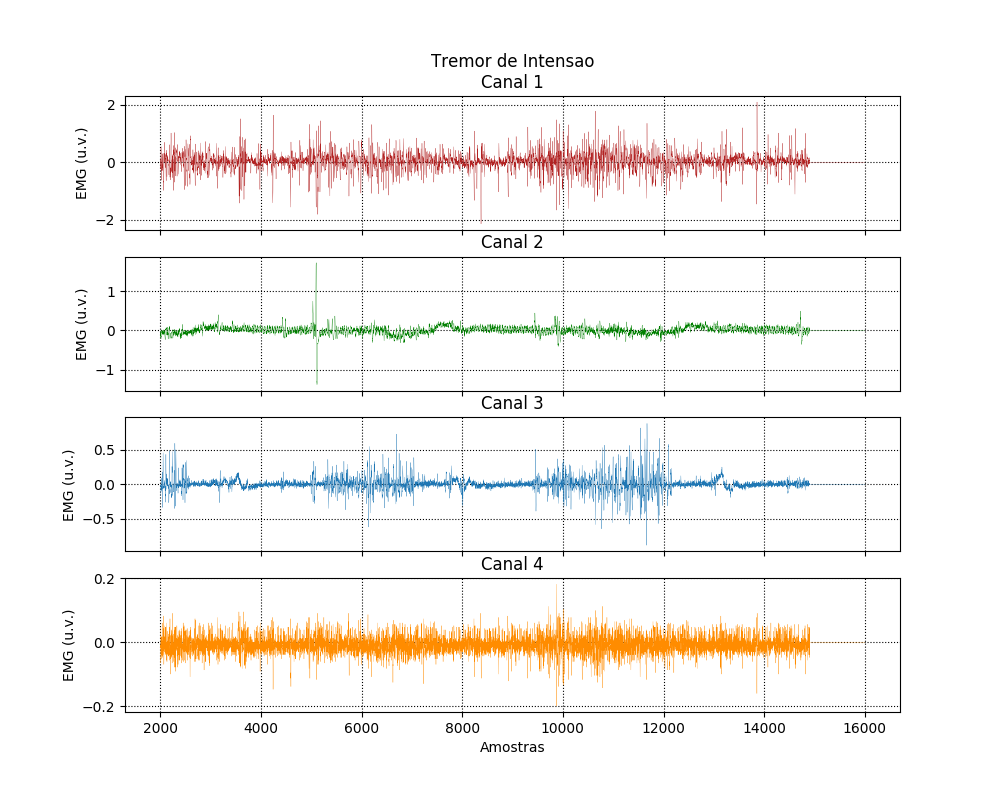

In [34]:
PlotFile(dfn)

In [35]:
for i in files:
    Xc = Rms(i)
    np.save('./DB_INTENC/preproc/'+i+'_rms', Xc, allow_pickle=False)
    print i+'_rms.npy'

p1v_rms.npy
p2v_rms.npy
p3v_rms.npy
p4v_rms.npy
p5v_rms.npy
p6v_rms.npy
c1v_rms.npy
c2v_rms.npy
c3v_rms.npy
c4v_rms.npy
c5v_rms.npy


In [36]:
c = np.load('DB_INTENC/preproc/p1v_rms.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,44.537192,7.559818,18.959109,25.976221
1,44.625654,7.583042,19.512969,25.987871
2,44.652662,7.607774,20.306241,26.098226
3,44.692366,7.280775,21.180114,26.114275
4,45.297386,7.296239,22.324117,26.340057


In [37]:
Rms('p1v').head()

,Ch1,Ch2,Ch3,Ch4
0,44.537192,7.559818,18.959109,25.976221
1,44.625654,7.583042,19.512969,25.987871
2,44.652662,7.607774,20.306241,26.098226
3,44.692366,7.280775,21.180114,26.114275
4,45.297386,7.296239,22.324117,26.340057


<IPython.core.display.Javascript object>


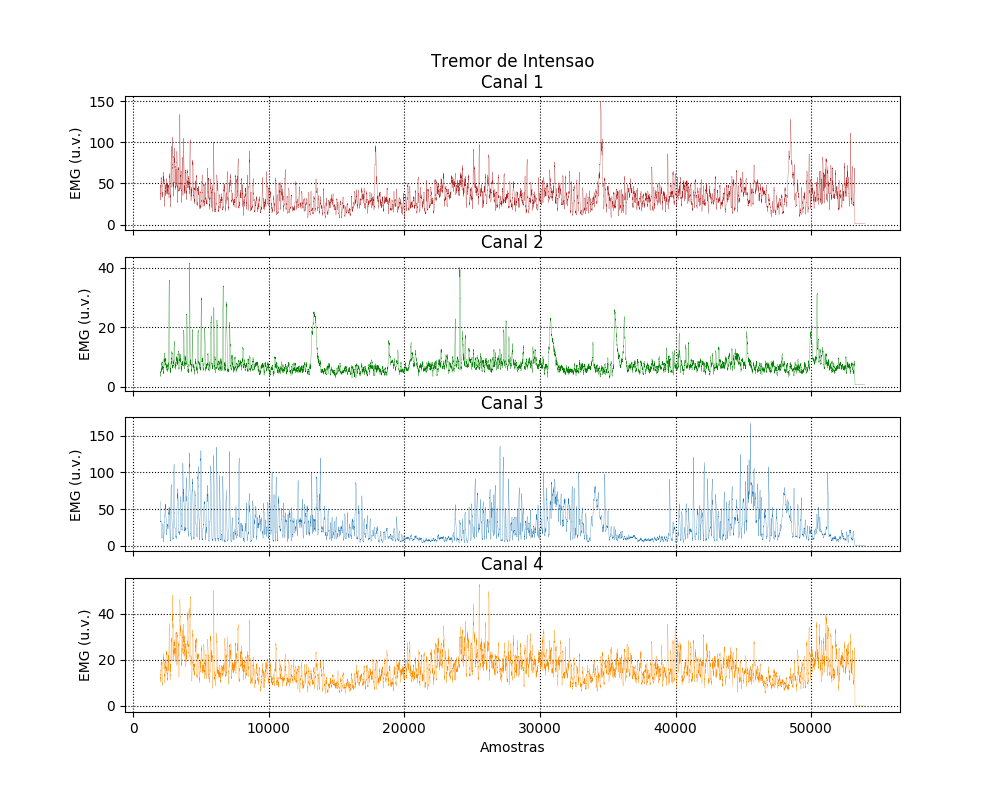

In [38]:
PlotFile(dfn)

In [39]:
for i in files:
    c = np.load('DB_INTENC/preproc/'+i+'_rms.npy')
    df = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
    #Nomeia cada coluna "canal"
    df = df.rename(columns={0: 'Ch1'})
    df = df.rename(columns={1: 'Ch2'})
    df = df.rename(columns={2: 'Ch3'})
    df = df.rename(columns={3: 'Ch4'})

    Xc = df.copy()
    Xc['Ch1'] = FilterSignal(df['Ch1'], low_pass=10)
    Xc['Ch2'] = FilterSignal(df['Ch2'], low_pass=10)
    Xc['Ch3'] = FilterSignal(df['Ch3'], low_pass=10)
    Xc['Ch4'] = FilterSignal(df['Ch4'], low_pass=10)
    
    np.save('./DB_INTENC/preproc/'+i+'_filt', Xc, allow_pickle=False)
    print i+'_filt.npy'

p1v_filt.npy
p2v_filt.npy
p3v_filt.npy
p4v_filt.npy
p5v_filt.npy
p6v_filt.npy
c1v_filt.npy
c2v_filt.npy
c3v_filt.npy
c4v_filt.npy
c5v_filt.npy


In [40]:
df.head()

,Ch1,Ch2,Ch3,Ch4
0,13.159757,24.448196,7.546113,5.068958
1,13.374236,24.450106,7.542109,5.036821
2,13.810479,24.474785,7.531033,5.008621
3,13.964090,24.460098,7.564211,4.989053
4,14.149545,24.505011,7.581600,5.167955


In [41]:
c = np.load('DB_INTENC/preproc/p2v_filt.npy')

dfn = pd.DataFrame(data=c, columns=['Ch1','Ch2','Ch3','Ch4'])
dfn.head()

,Ch1,Ch2,Ch3,Ch4
0,-0.346989,0.053614,-0.320281,-0.134939
1,-0.302695,-0.103246,-0.087896,-0.121287
2,-0.270807,-0.157552,0.089645,-0.146422
3,-0.316800,-0.070195,0.163170,-0.190233
4,-0.455849,0.078670,0.137171,-0.204147


<IPython.core.display.Javascript object>


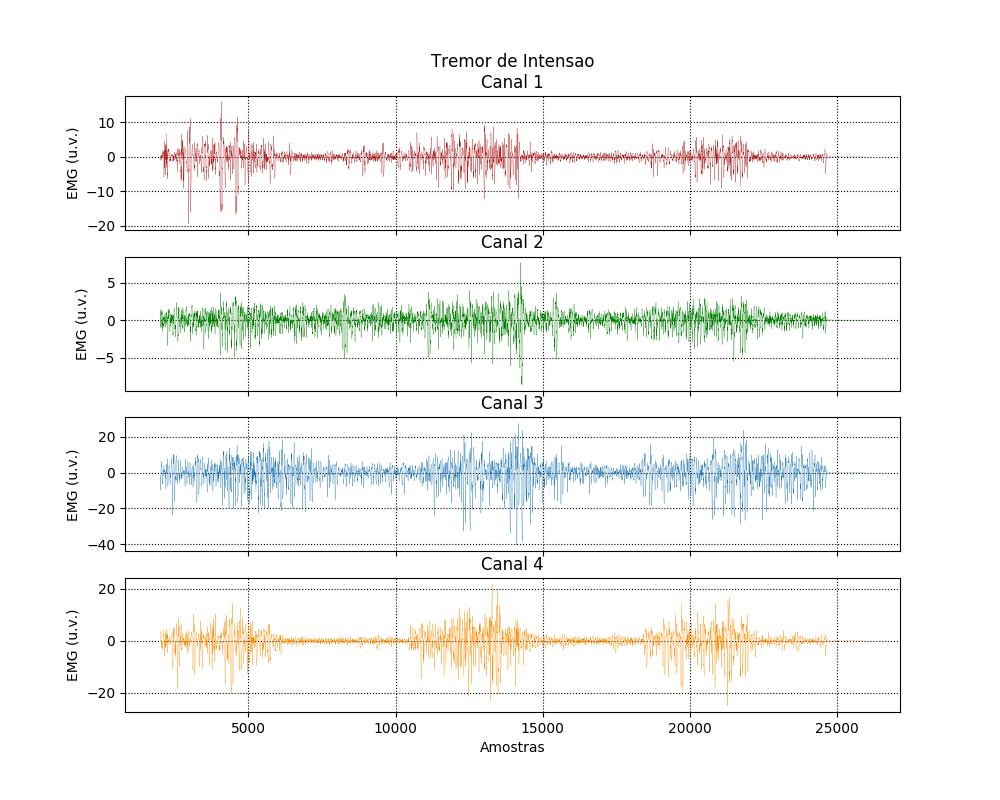

In [42]:
PlotFile(dfn)

<IPython.core.display.Javascript object>


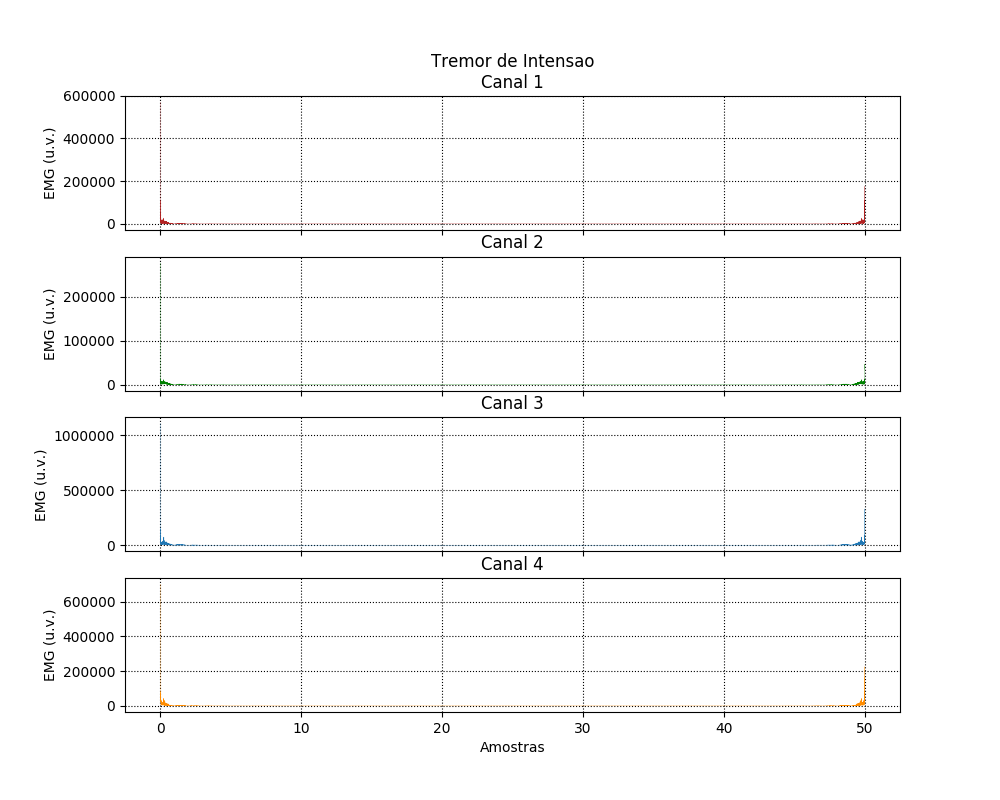

In [44]:
c = np.load('DB_INTENC/preproc/p2v_rms.npy')
PlotFft(c, 50)

[0, 1, 2, 3]